In [34]:
# System related and data input controls
import os

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Library
import pandas as pd
import numpy as np
import math

# Visualization
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 한글 설정
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

In [56]:
FILE_PATH = '../dataset/실습데이터.csv'

df = pd.read_csv(FILE_PATH, parse_dates=['Timestamp'])
print("✅ 데이터 로드 성공.")
print("original shape: ", df.shape)

✅ 데이터 로드 성공.
original shape:  (579297, 57)


In [57]:
df.columns = df.columns.str.replace('.xlsx', '', regex=False)

# 전체 데이터 시계열 그래프 도출

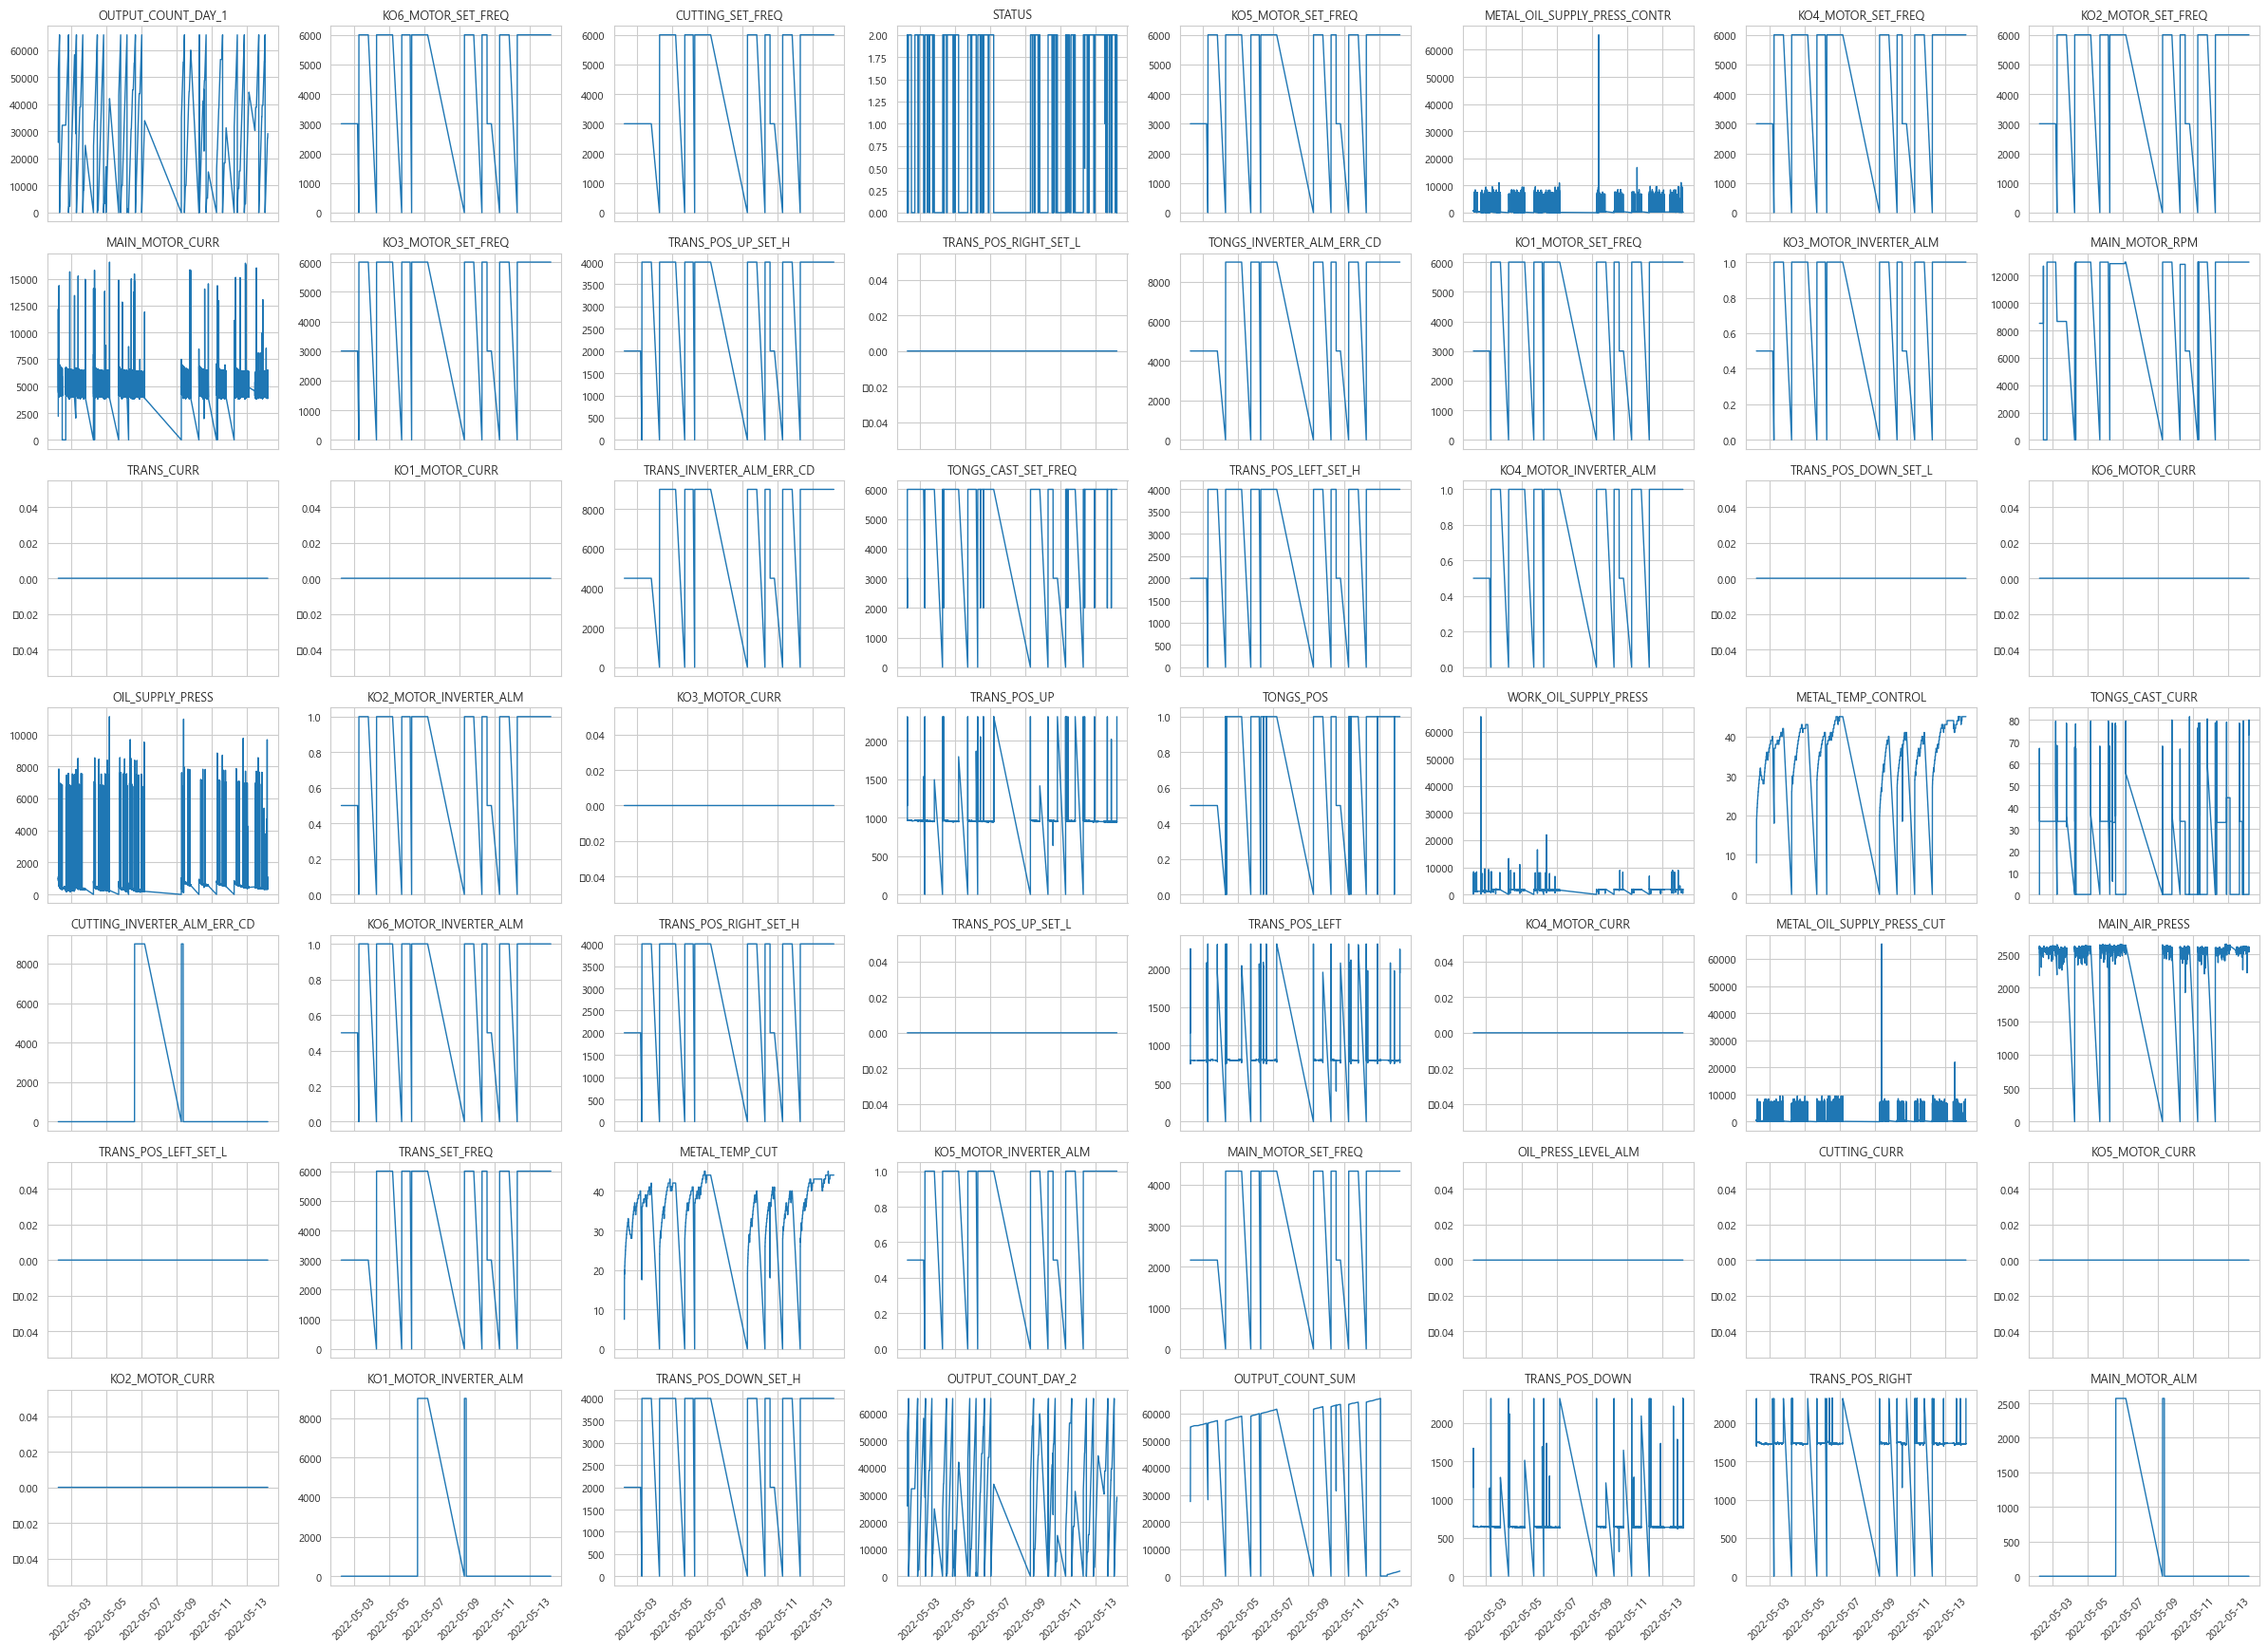

In [58]:
# 3. Timestamp를 인덱스로 설정
df = df.set_index('Timestamp')

# 4. 그래프 설정
num_cols = len(df.columns)
cols_per_row = 8
num_rows = math.ceil(num_cols / cols_per_row)

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(24, num_rows * 2.5), sharex=True)
axes = axes.flatten()  # 2차원 배열을 1차원으로

# 5. 각 컬럼별로 선 그래프 그리기
for i, col in enumerate(df.columns):
    axes[i].plot(df.index, df[col], linewidth=1)
    axes[i].set_title(col, fontsize=9)
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

# 6. 남는 subplot 숨기기
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# 공정이 끊긴 구간 분석

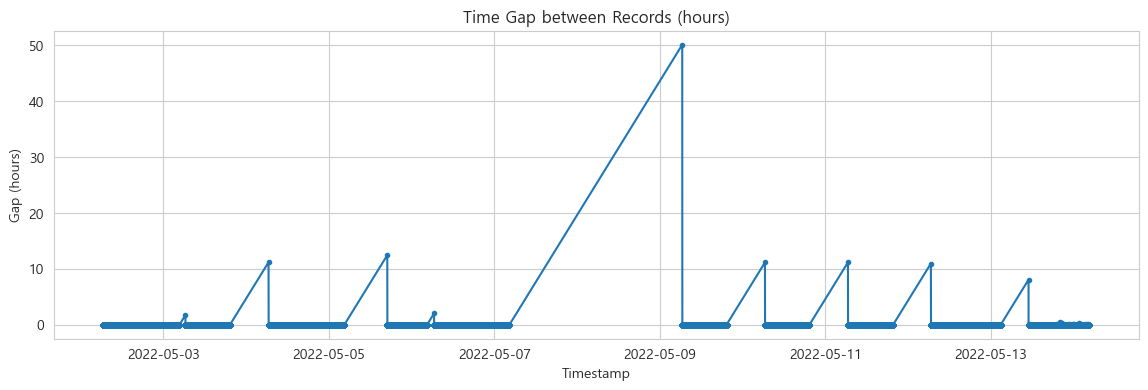

끊긴 구간 수: 16


In [38]:
# 1. 인접한 시점 간 시간 간격 계산
df['time_diff'] = df.index.to_series().diff()

# 2. 시간 간격 시각화
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['time_diff'].dt.total_seconds() / 3600, marker='o', markersize=3)
plt.title('Time Gap between Records (hours)')
plt.ylabel('Gap (hours)')
plt.xlabel('Timestamp')
plt.show()

# 3. 끊긴 구간 개수
threshold = pd.Timedelta(hours=0.1)  # 예: 30분 이상이 넘으면 끊겼다고 판단
gaps = df[df['time_diff'] > threshold]
print("끊긴 구간 수:", len(gaps))


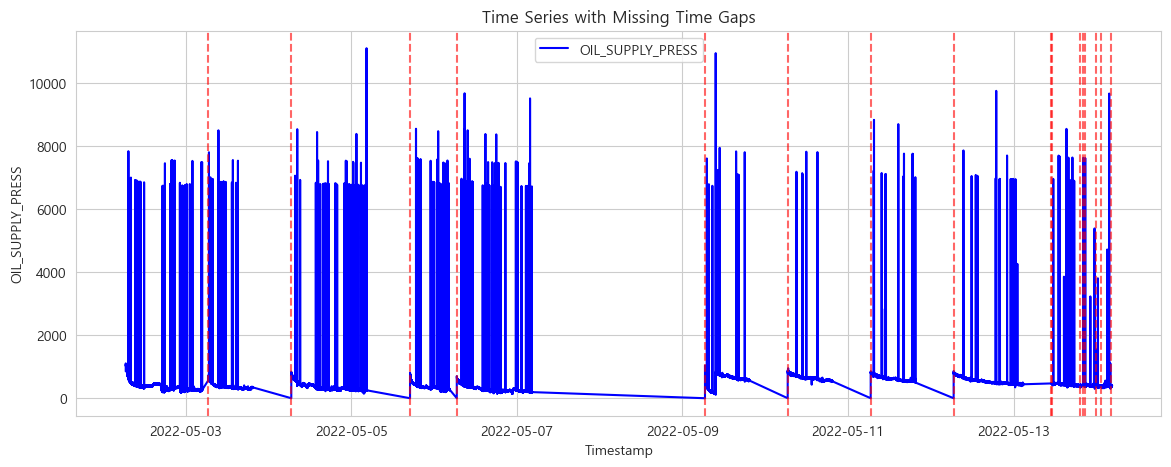

In [39]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['OIL_SUPPLY_PRESS'], color='blue', label='OIL_SUPPLY_PRESS')

# 끊긴 구간 표시
for gap_time in gaps.index:
    plt.axvline(x=gap_time, color='red', linestyle='--', alpha=0.6)

plt.title('Time Series with Missing Time Gaps')
plt.xlabel('Timestamp')
plt.ylabel('OIL_SUPPLY_PRESS')
plt.legend()
plt.show()


In [40]:
# 1. 끊긴 구간 탐지
threshold = pd.Timedelta(hours=0.5)
gaps = df[df['time_diff'] > threshold]

# 2. 각 끊긴 구간의 시작/끝/시간 차이 계산
gap_info = []
for gap_time in gaps.index:
    start_time = df.index[df.index.get_loc(gap_time) - 1]  # 끊기기 전 마지막 시점
    end_time = gap_time                                   # 끊긴 후 첫 시점
    gap_duration = end_time - start_time
    gap_info.append({
        'Gap Start': start_time,
        'Gap End': end_time,
        'Gap Duration': gap_duration
    })

# 3. DataFrame으로 보기 좋게 출력
gap_df = pd.DataFrame(gap_info)
print("🔴 끊긴 구간 요약:")
print(gap_df)

# 4. 총 손실 시간 요약
total_gap = gap_df['Gap Duration'].sum()
print(f"\n⏱ 총 끊긴 시간: {total_gap}")

🔴 끊긴 구간 요약:
            Gap Start             Gap End    Gap Duration
0 2022-05-03 04:43:32 2022-05-03 06:27:02 0 days 01:43:30
1 2022-05-03 19:22:48 2022-05-04 06:33:18 0 days 11:10:30
2 2022-05-05 04:32:45 2022-05-05 16:59:24 0 days 12:26:39
3 2022-05-06 04:31:53 2022-05-06 06:32:53 0 days 02:01:00
4 2022-05-07 04:24:51 2022-05-09 06:31:30 2 days 02:06:39
5 2022-05-09 19:22:10 2022-05-10 06:30:37 0 days 11:08:27
6 2022-05-10 19:25:08 2022-05-11 06:34:40 0 days 11:09:32
7 2022-05-11 19:40:51 2022-05-12 06:38:00 0 days 10:57:09
8 2022-05-13 02:53:11 2022-05-13 10:57:08 0 days 08:03:57

⏱ 총 끊긴 시간: 4 days 22:47:23


# 컬럼 별 상관관계

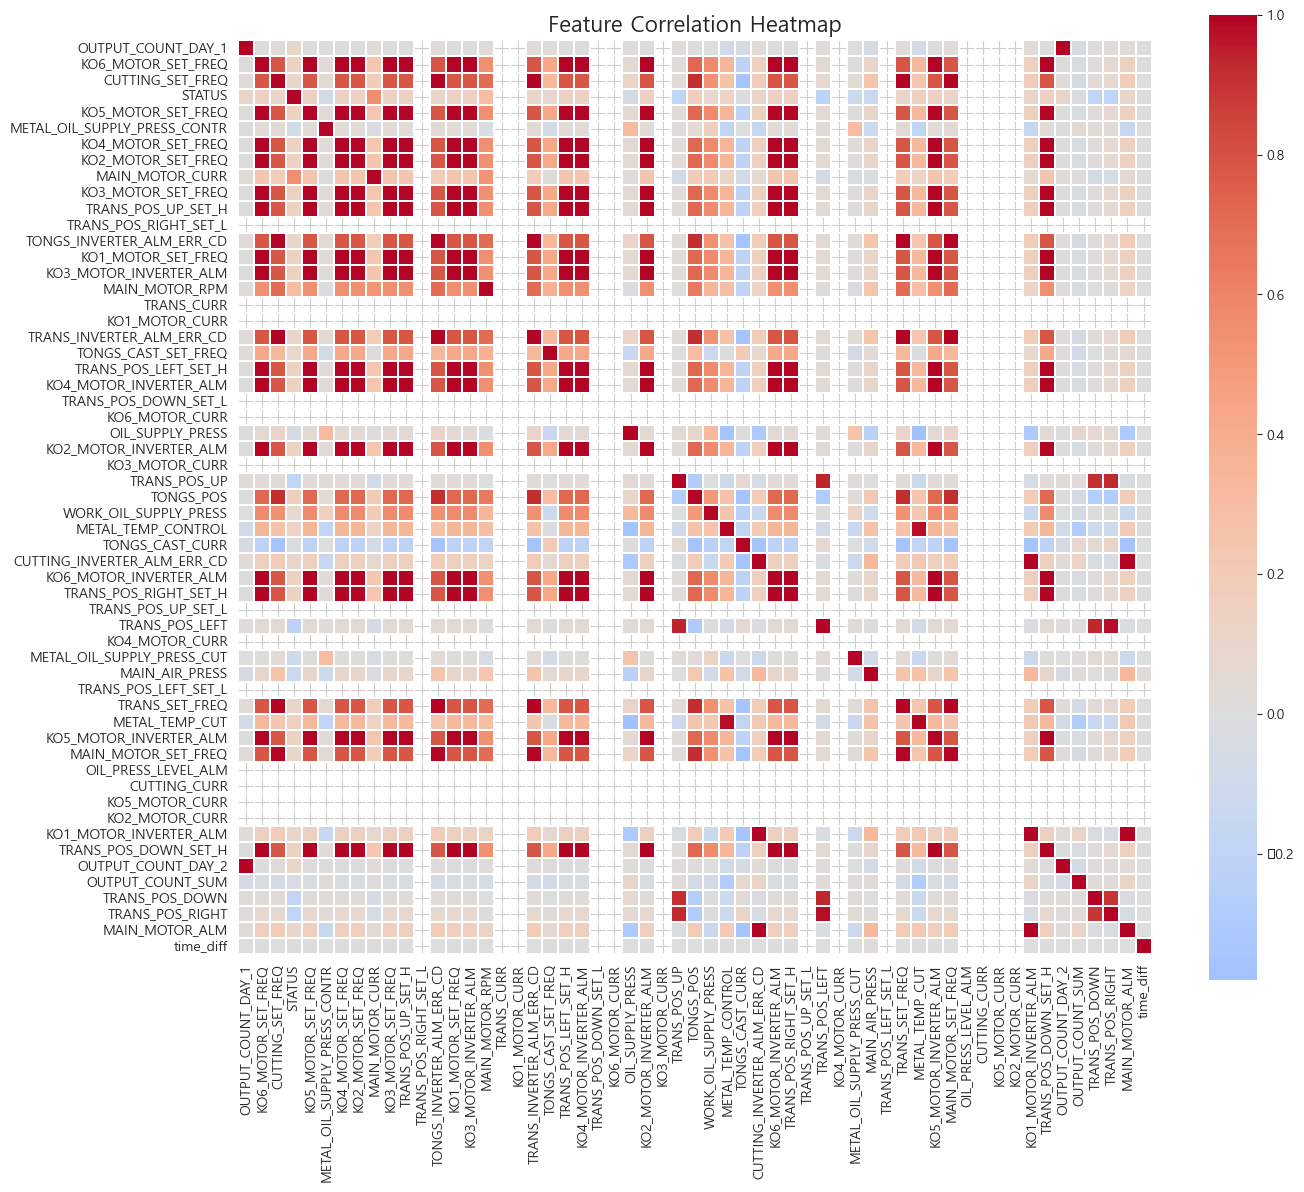

In [41]:
# 2. Timestamp 제외 (상관계수는 숫자형 데이터만)
df_numeric = df.select_dtypes(include=['number'])

# 3. 상관계수 계산
corr = df_numeric.corr()

# 4. 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap='coolwarm', center=0, square=True,
            annot=False, fmt='.2f', linewidths=0.3)

plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

# STATUS 의미 도출

In [43]:
import pandas as pd
import numpy as np

# 1. 'STATUS'가 0.5인 불리언 시리즈 생성
is_fault = (df['STATUS'] == 0.5)

# 2. 연속 구간의 시작점과 끝점 찾기
#    - 시작점: True이고 이전 값이 False였을 때 (True - False = 1)
#    - 끝점: True이고 다음 값이 False이거나 끝일 때 (True - False = 1)
#      (Series.shift(1)은 이전 값과 비교, Series.shift(-1)은 다음 값과 비교)

# 시작점: 현재가 True이고 이전이 False (또는 Nan)일 때
# diff()를 사용하기 위해 불리언을 정수로 변환 (True=1, False=0)
start_points = (is_fault.astype(int).diff() == 1) | (is_fault & is_fault.shift(1).isnull())

# 끝점: 현재가 True이고 다음이 False이거나 시리즈의 끝일 때
# diff()를 사용하기 위해 불리언을 정수로 변환
end_points = (is_fault.astype(int).diff(periods=-1) == 1) | (is_fault & is_fault.shift(-1).isnull())

# 3. 시작점과 끝점의 인덱스(Timestamp) 추출
start_timestamps = df[start_points].index.tolist()
end_timestamps = df[end_points].index.tolist()

# 4. 결과 출력 포맷팅
if len(start_timestamps) != len(end_timestamps):
    print("경고: 시작점과 끝점의 개수가 일치하지 않습니다. 데이터 끝점을 확인하세요.")
    # 오류 방지를 위해 더 짧은 리스트의 길이를 사용
    num_intervals = min(len(start_timestamps), len(end_timestamps))
else:
    num_intervals = len(start_timestamps)

print("--- 'STATUS' 0.5 연속 구간 (Start ~ End) ---")
for i in range(num_intervals):
    print(f"구간 {i+1}: Start = {start_timestamps[i]} | End = {end_timestamps[i]}")

# 참고: 만약 끝점이 데이터의 맨 마지막까지 이어질 경우,
#       마지막 'end_timestamps' 값은 전체 데이터의 마지막 타임스탬프와 일치할 수 있습니다.

--- 'STATUS' 0.5 연속 구간 (Start ~ End) ---
구간 1: Start = 2022-05-04 23:13:32 | End = 2022-05-04 23:21:48
구간 2: Start = 2022-05-06 14:38:02 | End = 2022-05-06 14:44:45
구간 3: Start = 2022-05-09 18:11:12 | End = 2022-05-09 18:18:53
구간 4: Start = 2022-05-12 08:21:38 | End = 2022-05-12 08:37:09


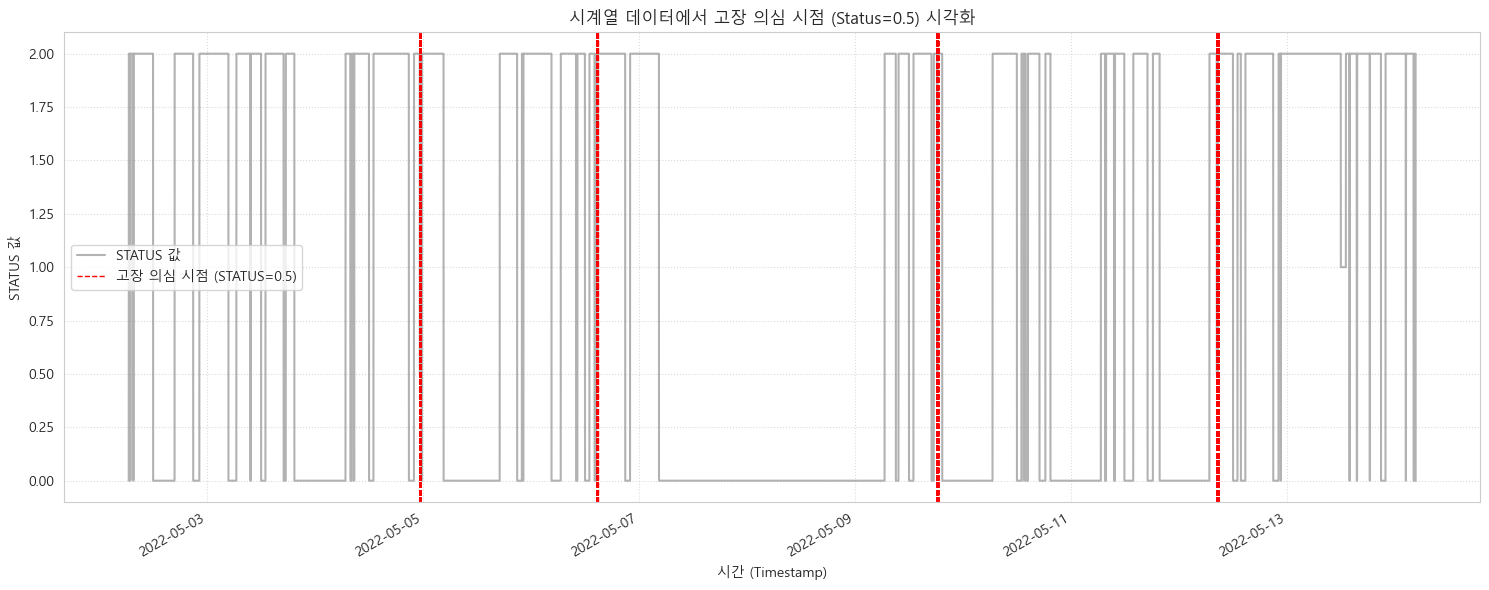

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. 'Status'가 0.5인 시점의 인덱스(Timestamp) 추출
fault_timestamps = df[df['STATUS'] == 0.5].index

# 2. Status 컬럼을 시각화의 기준으로 사용 (보통 센서 값 등 다른 주요 컬럼을 사용합니다)
# 여기서는 Status 컬럼 자체를 플롯하여 0.5 지점을 명확히 보겠습니다.
plt.figure(figsize=(15, 6))

# A. 전체 'Status' 변화를 라인 플롯으로 표시 (배경 정보)
df['STATUS'].plot(kind='line', color='gray', alpha=0.6, label='STATUS 값')

# B. 'Status'가 0.5인 시점에 수직선(Vertical Line) 표시
for timestamp in fault_timestamps:
    # axvline을 사용하여 고장 시점에 수직선을 그립니다.
    plt.axvline(x=timestamp, color='red', linestyle='--', linewidth=1, label='고장 의심 시점 (STATUS=0.5)')

# 3. 플롯 꾸미기
plt.title('시계열 데이터에서 고장 의심 시점 (Status=0.5) 시각화')
plt.xlabel('시간 (Timestamp)')
plt.ylabel('STATUS 값')

# 라벨 중복 제거 및 범례 표시
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys())

plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

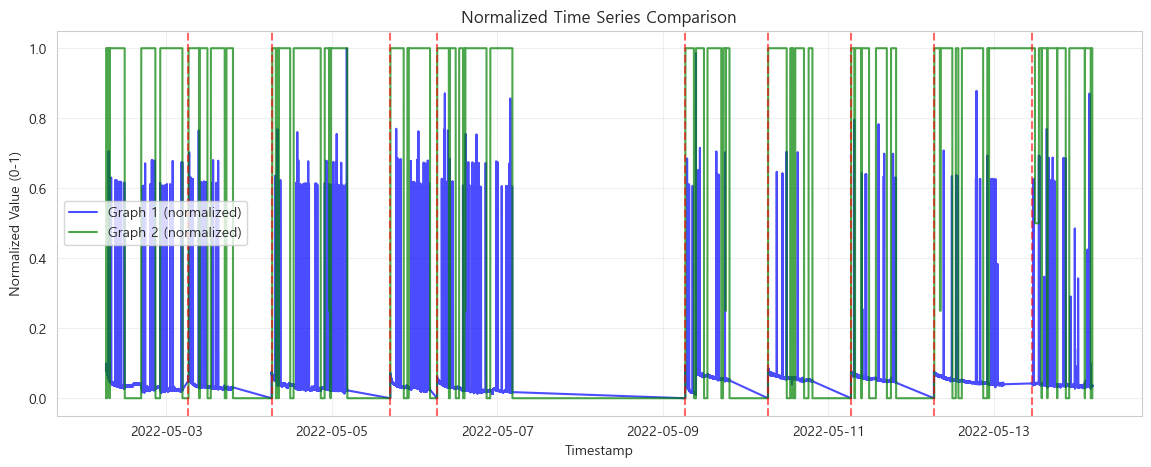

In [50]:
from sklearn.preprocessing import MinMaxScaler

# MinMax 스케일러 생성
scaler = MinMaxScaler()

# 각 시계열을 0~1 범위로 정규화
df['OIL_SUPPLY_PRESS_norm1'] = scaler.fit_transform(df[['OIL_SUPPLY_PRESS']])
df['STATUS'] = scaler.fit_transform(df[['STATUS']])  # 다른 데이터라면 여기 변경

# 한 그래프에 그리기
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['OIL_SUPPLY_PRESS_norm1'], color='blue', label='Graph 1 (normalized)', alpha=0.7)
plt.plot(df.index, df['STATUS'], color='green', label='Graph 2 (normalized)', alpha=0.7)

# 끊긴 구간 표시
for gap_time in gaps.index:
    plt.axvline(x=gap_time, color='red', linestyle='--', alpha=0.6)

plt.title('Normalized Time Series Comparison')
plt.xlabel('Timestamp')
plt.ylabel('Normalized Value (0-1)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 군집 별 의미 도출

In [62]:
# 'MAIN'과 'METAL'이 모두 포함된 컬럼 이름 추출
selected_columns = [col for col in df.columns if 'MAIN' in col or 'METAL' in col]

print(selected_columns)

['METAL_OIL_SUPPLY_PRESS_CONTR', 'MAIN_MOTOR_CURR', 'MAIN_MOTOR_RPM', 'METAL_TEMP_CONTROL', 'METAL_OIL_SUPPLY_PRESS_CUT', 'MAIN_AIR_PRESS', 'METAL_TEMP_CUT', 'MAIN_MOTOR_SET_FREQ', 'MAIN_MOTOR_ALM']


In [66]:
selected_columns = [col for col in df.columns if 'OUTPUT' in col]

print(selected_columns)

['OUTPUT_COUNT_DAY_1', 'OUTPUT_COUNT_DAY_2', 'OUTPUT_COUNT_SUM']


In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. 인덱스 재구성 및 NaN을 0으로 채우기 ---

# 1-1. 데이터의 최소/최대 시간 인덱스 확인
start_date = df.index.min()
end_date = df.index.max()

# 1-2. 초 단위(second)의 빈도(frequency='S')로 전체 인덱스 생성
# 'S'는 Second를 의미합니다.
data_freq = 'S'

# 시작부터 끝까지 설정된 빈도(초 단위)로 연속된 전체 인덱스를 생성
# 주의: 57만 행이 초 단위로 몇 일/시간을 커버하는지 확인해야 합니다.
# 57만 초는 약 6.6일입니다. 이 기간 전체의 초를 모두 인덱스로 만들게 됩니다.
full_index = pd.date_range(start=start_date, end=end_date, freq=data_freq)

# 1-3. 원본 데이터프레임을 전체 인덱스에 맞게 재색인(reindex)합니다.
# 데이터가 없는 초 지점은 자동으로 NaN이 됩니다.
df_filled = df.reindex(full_index)

# 1-4. NaN 값을 0으로 채웁니다. (이것이 핵심!)
df_filled = df_filled.fillna(0)

print(f"원본 데이터 행 수: {len(df)}")
print(f"채워진 데이터 행 수 (총 초 수): {len(df_filled)}")
print("데이터 준비 완료.")

원본 데이터 행 수: 579297
채워진 데이터 행 수 (총 초 수): 1029734
데이터 준비 완료.


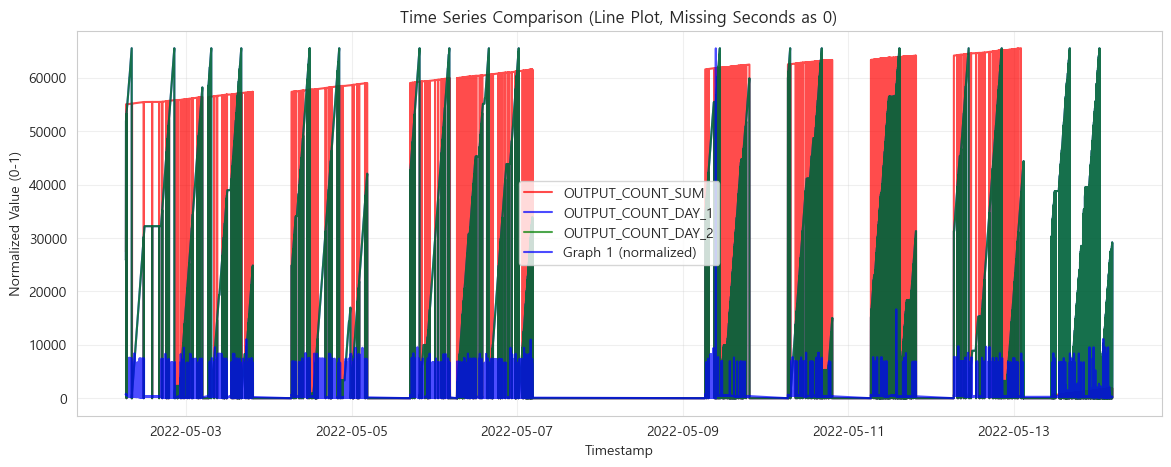

In [84]:
# --- A. 선 그래프 그리기 (Line Plot) ---

plt.figure(figsize=(14, 5))

# 이제 df_filled를 사용하여 그래프를 그립니다.
plt.plot(df_filled.index, df_filled['OUTPUT_COUNT_SUM'], color='red', label='OUTPUT_COUNT_SUM', alpha=0.7)
plt.plot(df_filled.index, df_filled['OUTPUT_COUNT_DAY_1'], color='blue', label='OUTPUT_COUNT_DAY_1', alpha=0.7)
plt.plot(df_filled.index, df_filled['OUTPUT_COUNT_DAY_2'], color='green', label='OUTPUT_COUNT_DAY_2', alpha=0.7)
plt.plot(df.index, df['METAL_OIL_SUPPLY_PRESS_CONTR'], color='blue', label='Graph 1 (normalized)', alpha=0.7)

plt.title('Time Series Comparison (Line Plot, Missing Seconds as 0)')
plt.xlabel('Timestamp')
plt.ylabel('Normalized Value (0-1)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()